## Spectral Analysis of Global Holocene Dataset with `Pyleoclim`

In this notebook, we demonstrate how to use `Pyleoclim` to conduct spectral analysis of moisture records from the Holocene Abrupt Change dataset found on the [lipdverse](https://lipdverse.org/HoloceneAbruptChange/0_9_0/). This notebook is very similar to the Temperature 12k example notebook, the important distinction being that we will be parsing for moisture records rather than temperature.

Once the LiPD files are ready, we may start the analysis. First, let's import some useful packages, including `Pyleoclim`. Note that we are using the `Development` branch of it, and we will make an alias of it as pyleo.

In [ ]:
# load pacakges
%load_ext autoreload
%autoreload 2
    
import pyleoclim as pyleo
import os
import numpy as np
from tqdm import tqdm 
import pickle

import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

## Load LiPD files with `Pyleoclim`

Suppose the LiPD files of the dataset are stored in the folder named "HoloceneAbruptChange0_9_0", to load the whole dataset, simply use `pyleo.Lipd()` with its argument usr_path pointing to the relative path of the folder. The resultant dataset is a LiPD utility object that has a method called `to_tso()`, which will extract the timeseries records to a Python list for us.

In [ ]:
# load the LiPD Dataset
dataset = pyleo.Lipd(usr_path = '../HoloceneAbruptChange0_9_0')

# convert the input dataset into a list of LiPD timeseries objects
# each object is essentially a dictionary
ts_list = dataset.to_tso()

## Define `Pyleoclim.Series()` objects

Once we have the timeseries records from the LiPD files, we may loop over each record and convert it to a `Pyleoclim.Series()` object, which has a collection of handy methods for data analysis.

Note that we use a dictionary called `ts_M` to store each record, with the key name as the `dataSetName` from each record. We also store the latitude information of each record into a dictionary called `lats_M`.

We also employ variables `flag` and `subflag` in order to isolate the moisture flag "M". Each LiPD file contains dictionaries with various metadata. For this example we are interested in the examination of datasets which have been flagged as containing moisture record data. This metadata can be found in the `paleoData_interpretation` dictionary, which contains a single list. Within this list is the value `variable`, which contains the relevant information.

Note: The LiPD metadata structure is subject to regular change, so some data exploration/literature review may be necessary when parsing for specific data from any given LiPD release.

In [ ]:
ts_M = {} # the dictionary for pyleoclim timeseries units
lats_M = {} # the dictionary for latitude measurements

# load the data pertaining to moisture records
# flag = 'paleoData_variableName' this works for stuff like temperature or precipitation
flag = 'paleoData_interpretation'
subflag = 'variable'

# a list of problematic records which we will skip
skip_list = [
    'GRIP.Vinther.2006',
    'Vuoksjavratje.Berntsson.2014',
    'Sigrid.Nazarova.2017',
    'DavisLake.Barnosky.1981',
    'Ammersee.vonGrafenstein.1996',
    'Temje.Nazarova.2013',
    'Macal.Akers.2016',
    'NevadaPrecip.Hughes.1996',
]

def replaceNaN(value):
    ''' replace "nan" in value with np.nan
    '''
    value_list = []
    for v in value:
        if v == 'nan':
            value_list.append(np.nan)
        else:
            value_list.append(v)
            
    return value_list

for item in tqdm(ts_list):
    dsn = item['dataSetName']
    if flag in item.keys() and subflag in item[flag][0] and item[flag][0][subflag] == 'M': # Parsing for the moisture flag
        value = item['paleoData_values']
        value = replaceNaN(value)
            
        if 'year' in item.keys():
            year = item['year']
            year = replaceNaN(year)
            
        elif 'age' in item.keys():
            age = item['age']
            age = replaceNaN(age)
            year = 1950-np.array(age)
        else:
            # no time axis, skip
            continue
            
        # define the Pyleoclim timseries object and
        # store in a dictionary with dataSetName as the key
        if dsn in skip_list:
            continue
        
        ts_M[dsn] = pyleo.Series(time=year, value=value)
        lats_M[dsn] = item['geo_meanLat']
    
            
print('# of loaded timeseries:', len(ts_M))

# Dump to a pickle file for quick load in the future
with open('../lats_M_dict.pkl', 'wb') as f:
    pickle.dump(lats_M, f)

## Spectral Analysis with `Pyleoclim`

### Applying the WWZ method

Now we are ready to perform spectral analysis for each `Series()` object.

We will first standardize each timeseries and then perform the WWZ (Weighted Wavelet Z-Transform) method for power spectral density (PSD) calculation. In `Pyleoclim`, those two steps can be a one line call. Suppose the timeseries objection is named as `ts_obj`, then `ts_obj.standardize()` will perform the standardization process, and we can append `.spectral()` to perform spectral analysis on the standardized timeseries directly. In short, it's simply `ts_obj.standardize().spectral()`, whose output is a `Pyleoclim.PSD()` object and it will be stored in a dictionary for each record.

There are several important arguments for the .spectral() method though, including:

1. `method` - here we use the default option `wwz`, so this argument can be ignored
2. `freq_method` - here we use the default option `log`, which means a log-space frequency vector for analysis, so this argument can be ignored
2. `freq_kwargs` - here we specify the length of the frequency vector `nfreq` to control the calculation speed (the longer the length, the longer time it will take)



In [ ]:
psd = {}  # the dictionary to store the spectral analysis result for each record

# spectral analysis for each record; it would take about half an hour for the calculation
for dsn, ts_obj in tqdm(ts_M.items()):
    nfreq = np.min([20, np.size(ts_obj.time)]) # length of the frequency vector as a control of the calculation speed
    if dsn not in psd.keys():
        psd[dsn] = ts_obj.standardize().spectral(
            method='wwz',  # the default option
            freq_method='log', # the default option
            freq_kwargs={'nfreq': nfreq}
        )

# Dump to a pickle file for quick load in the future
with open('../psd_objs.pkl', 'wb') as f:
    pickle.dump(psd, f)

### Scaling Slope Estimation

Once the PSD is calculated for each record, we may estimate the scaling slope $\beta$ of the PSD curves using the `.beta_est()` method on each PSD() object. We need to specify two arguments for the `.beta_est()` method:

1. `fmin`: which defines the minimum edge of the range for $\beta$ estimation
2. `fmax`: which defines the maxmimum edge of the range for $\beta$ estimation

We will calculate three sets of the scaling factors:

1. period over [10, 100] yrs
2. period over [100, 1000] yrs
3. period over [1000, 10000] yrs

In [52]:
# load the precalculated PSD objects
with open('../psd_objs.pkl', 'rb') as f:
    psd = pickle.load(f)

# Create lists to store beta values for the spectral analysis result
beta_S = []
beta_M = []
beta_L = []

# Calculating beta values for time scales of interest
for dsn, psd_obj in psd.items():
    beta_S.append(
        psd_obj.beta_est(fmin=1/100, fmax=1/10)['beta']
    )
    beta_M.append(
        psd_obj.beta_est(fmin=1/1000, fmax=1/100)['beta']
    )
    beta_L.append(
        psd_obj.beta_est(fmin=1/10000, fmax=1/1000)['beta']
    )

beta_S = np.array(beta_S)
beta_M = np.array(beta_M)
beta_L = np.array(beta_L)

# The lists contain nan results for psd objects not in their specified frequency domain, which we now remove
beta_S = beta_S[~np.isnan(beta_S)]
beta_M = beta_M[~np.isnan(beta_M)]
beta_L = beta_L[~np.isnan(beta_L)]

nS = len(beta_S)
nM = len(beta_M)
nL = len(beta_L)
print(nS, nM, nL)

17 72 15


## Visualization with Pyleoclim

First, it's easy to set the plotting style with `Pyleoclim`, simply use `pyleo.set_style()`, which has two important arguments:

1. `style` - a text string to specify which plotting style to use
2. `font_scale` - which can be used to scale the font sizes consistently for a figure Here we will use the default journal plotting style, with font_scale=1.5 for better readability. For more details of pyleo.set_style(), see this notebook.

`Pyleoclim` makes it also super easy for quick visualization of the Series() and PSD() objects. It's simply `Series.plot()` or `PSD.plot()`. Regarding `PSD.plot()`, we have several important arguments:

1. `ax` - if specified, the plot will be output to an existing matplotlib.axes object
2. `xlim` - if specified, the x-axis of the plot will be limited within the specified range
3. `ylim` - if specified, the y-axis of the plot will be limited within the specified range
4. `xlabel` - if specified, the x-axis will be labeled with the specified text string
5. `ylabel` - if specified, the y-axis will be labeled with the specified text string
6. `color` - if specified, the curve will be colored with the specified color
7. `mute` - if True, the figure object fig will not be visible, until pyleo.showfig(fig) is called

Note that we will specify ax when loop over records, so as to overlap multiple PSD curves into one figure, and we show how to do it below.

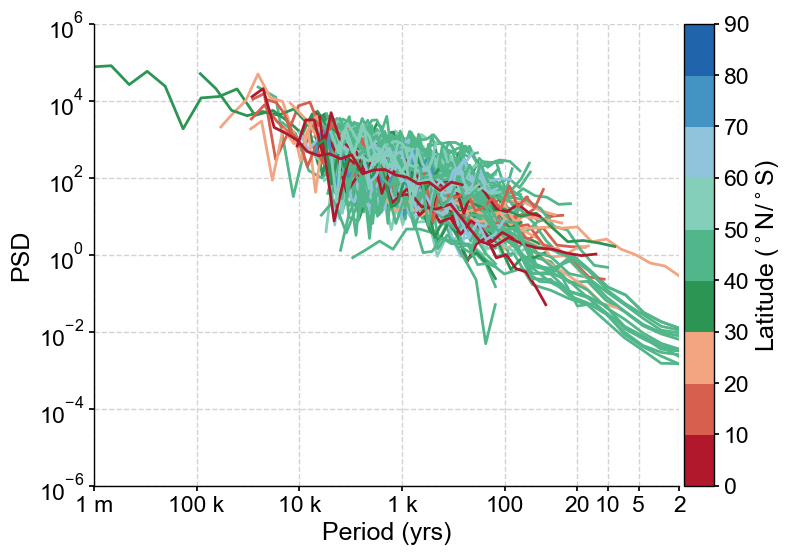

In [53]:
with open('../lats_M_dict.pkl', 'rb') as f:
    lats = pickle.load(f)
    
lat_list = [v for k, v in lats.items()]
cmap = sns.color_palette("RdBu_r", 9)[::-1]
cmap_green = sns.color_palette("BuGn_r")
cmap[3:6] = cmap_green[1:4]
color_ind_list = np.abs(lat_list)//10
color_ind_list = color_ind_list.astype(int)

# plot the PSD curves colored according to latitudes
    
# set the plotting style
pyleo.set_style(style='journal', font_scale=1.5)

period_ticks = [2, 5, 10, 20, 100, 1000, 10000, 100000, 1000000]
period_ticklabels = ['2', '5', '10', '20', '100', '1 k', '10 k', '100 k', '1 m']
    
dsns = psd.keys()
psd_obj = psd[list(dsns)[0]]
fig, ax = psd_obj.plot(mute=True, figsize=[8, 6]) # plot the first PSD curve
for dsn, psd_obj in psd.items():
    # loop over and plot the PSD curves of other records
    if dsn == list(dsns)[0]:
        pass
    else:
        i = list(dsns).index(dsn)
        psd_obj.plot(
            ax=ax, xlim=[1e6, 1e1], ylim=[1e-6, 1e6],
            xlabel='Period (yrs)', ylabel='PSD',
            color=cmap[color_ind_list[i]],
        )
        
ax.set_xticks(period_ticks)
ax.set_xticklabels(period_ticklabels)
        
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
clr_map = mpl.colors.ListedColormap(cmap)
cax = divider.append_axes("right", size="5%", pad=0.05)
bounds = np.linspace(0, 90, 10)
cb = mpl.colorbar.ColorbarBase(cax, cmap=clr_map, orientation='vertical', boundaries=bounds,
                               ticks=bounds)
cb.set_label(r'Latitude ($^\circ$N/$^\circ$S)')
        
pyleo.showfig(fig)

The PSD curves are now plotted, it's time to visualize the estimated scaling slopes - the $\beta$ values.

Below we show how to plot KDE (Kernel Density Estimation) of the $\beta$ values of those PSD curves utilizating another visualization package `Seaborn`. See the `Seaborn` [documentation](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) on `Seaborn.kdeplot()` for further details.

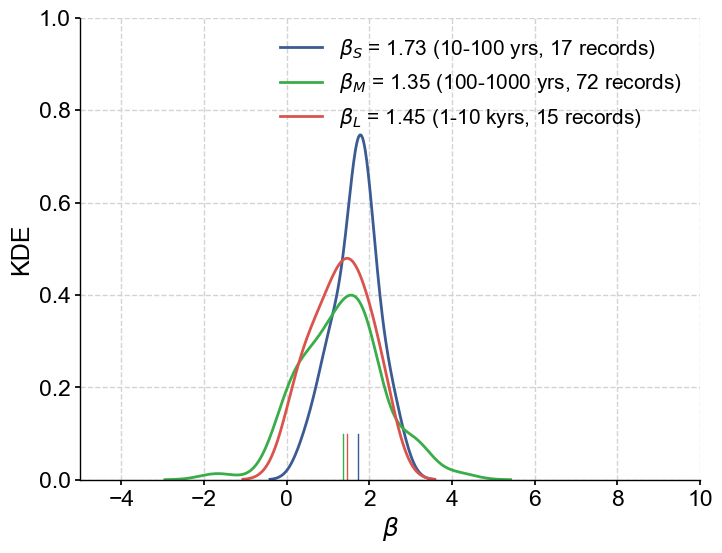

In [54]:
# set the plotting style
pyleo.set_style(style='journal', font_scale=1.5)

fig, ax = plt.subplots(figsize=[8, 6])
med_s = np.median(beta_S)
med_m = np.median(beta_M)
med_l = np.median(beta_L)
n_s = beta_S.shape[0]
n_m = beta_M.shape[0]
n_l = beta_L.shape[0]

ax.set_xlim([-5, 10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Plotting the KDE for beta values in each frequency regime
g1 = sns.kdeplot(beta_S, shade=False, color=sns.xkcd_rgb['denim blue'], linestyle='-',
                 label=r'$\beta_S$ = {:.2f} (10-100 yrs, {} records)'.format(med_s, n_s))
g1.axvline(x=med_s, ymin=0, ymax=0.1, linewidth=1, color=sns.xkcd_rgb['denim blue'],
           linestyle='-')

g2 = sns.kdeplot(beta_M, shade=False, color=sns.xkcd_rgb['medium green'], linestyle='-',
                 label=r'$\beta_M$ = {:.2f} (100-1000 yrs, {} records)'.format(med_m, n_m))
g2.axvline(x=med_m, ymin=0, ymax=0.1, linewidth=1, color=sns.xkcd_rgb['medium green'], linestyle='-')

g3 = sns.kdeplot(beta_L, shade=False, color=sns.xkcd_rgb['pale red'], linestyle='-',
                 label=r'$\beta_L$ = {:.2f} (1-10 kyrs, {} records)'.format(med_l, n_l))
g3.axvline(x=med_l, ymin=0, ymax=0.1, linewidth=1, color=sns.xkcd_rgb['pale red'], linestyle='-')

ax.set_ylim(0, 1)
ax.legend(fontsize=15, loc='upper right',  bbox_to_anchor=(1, 1))
ax.set_ylabel('KDE')
ax.set_xlabel(r'$\beta$')
pyleo.showfig(fig)